In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import shutil

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [3]:
curr_wv = np.arange(100, 3600, 10)
set_skip_factor = None
gpSplit = 0.2

[STATUS] Setting X, Y components for 5D Model.

Name : GP regression
Objective : 29538524.030714337
Number of Parameters : 10
Number of Optimization Parameters : 10
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  mul.rbf.variance         |    1.0  |      +ve      |        
  mul.rbf.lengthscale      |   (4,)  |      +ve      |        
  mul.linear.variances     |   (4,)  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        
[STATUS] Optimizing...
Optimization restart 1/3, f = 287709.74545296596
Optimization restart 2/3, f = 262155.2954014181
Optimization restart 3/3, f = 249559.02603475627
[STATUS] 36.27s taken to optimize.


GP_regression.,value,constraints,priors
mul.rbf.variance,47.00825764531416,+ve,
mul.rbf.lengthscale,"(4,)",+ve,
mul.linear.variances,"(4,)",+ve,
Gaussian_noise.variance,52.14533344784946,+ve,


index,GP_regression.mul.rbf.lengthscale,constraints,priors
[0],0.00002396,+ve,
[1],0.00000054,+ve,
[2],0.00051793,+ve,
[3],0.16216288,+ve,


[STATUS] Predicting X and Y with trained emulator.
[STATUS] 0.01s taken to predict single item.
[STATUS] Predicting X and Y with trained emulator.
[STATUS] 2.31s taken to predict every item.
[STATUS] 7.38s taken to save data.
Inside 3x: 6998, Total: 7000


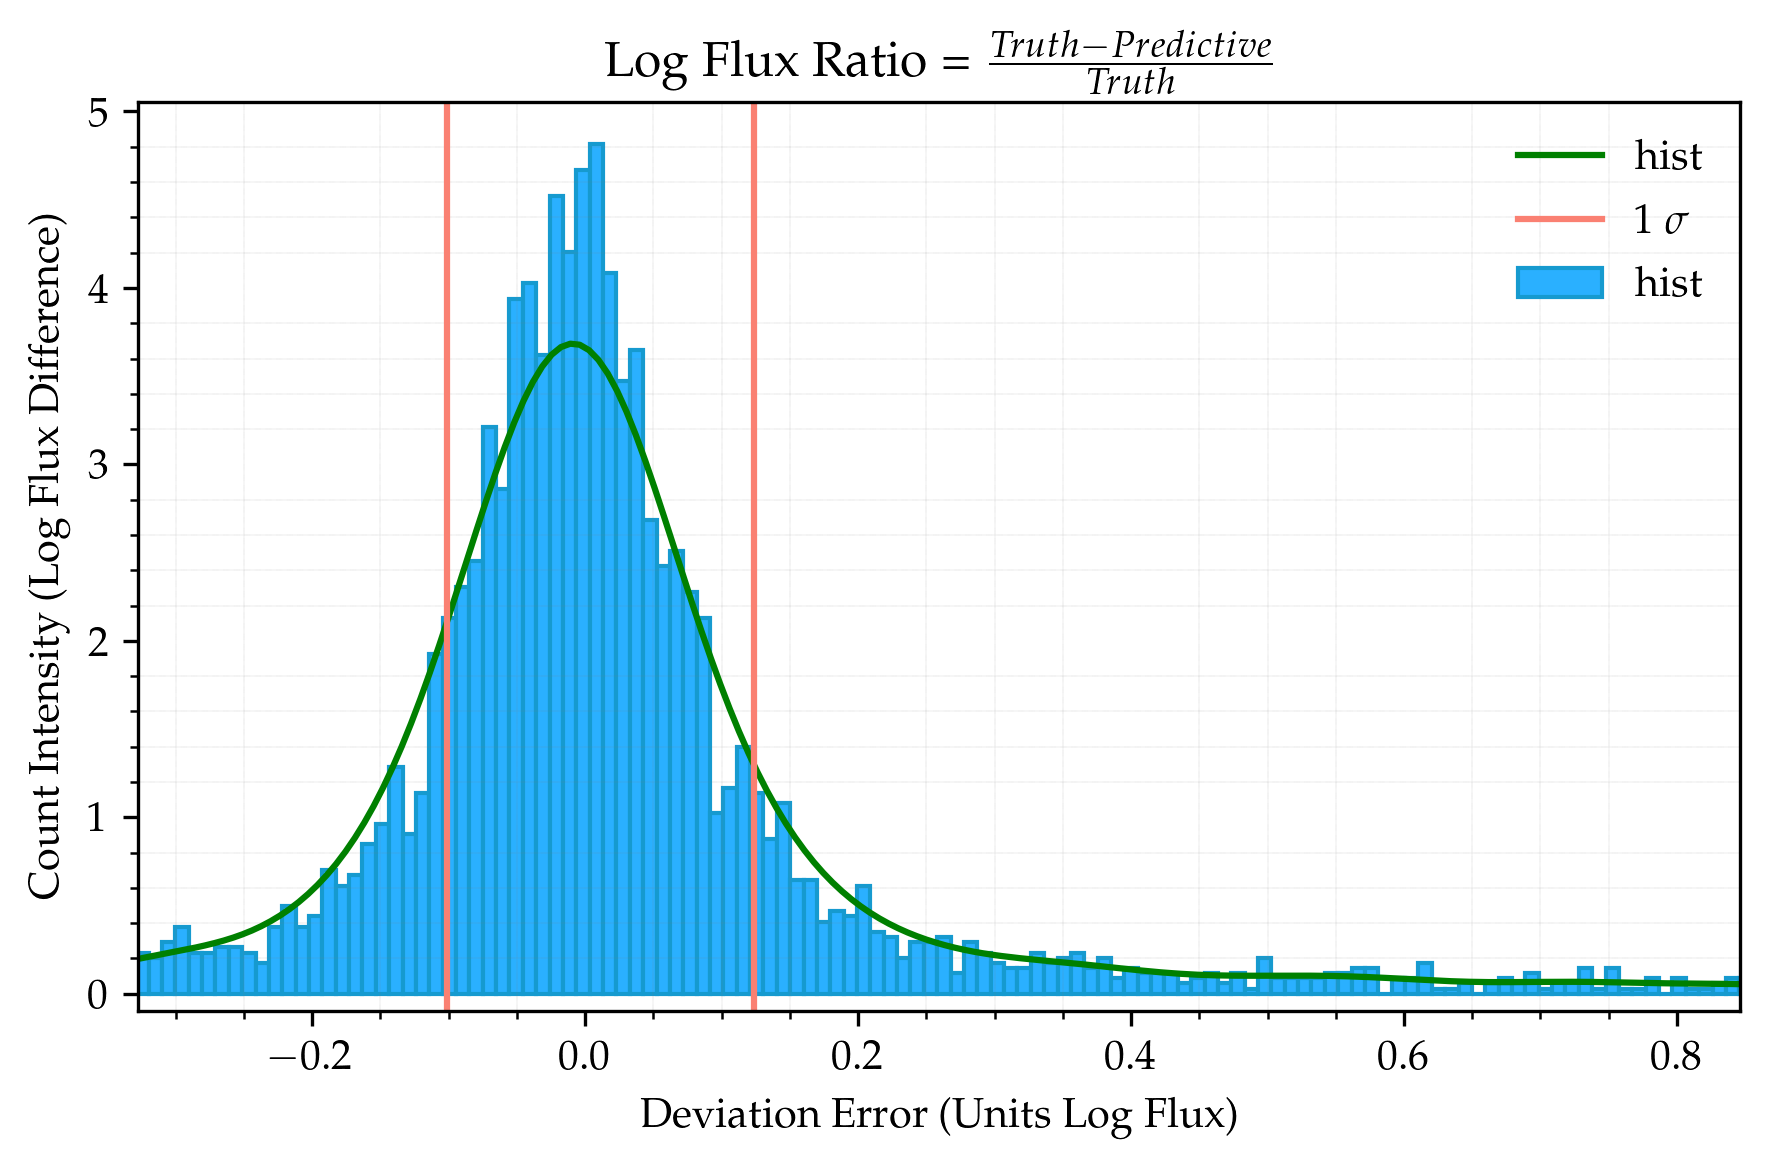

In [4]:
mejdyn = 0.01
mejwind =  0.13
phi = 45
iobs = 4


gp = GP5D("Classes/reference.csv")
gp.split = gpSplit
gp.emulator = "start"
gp.cross_validation = (mejdyn, mejwind, phi, iobs)
gp.set_wv_range(curr_wv)
gp.n_comp = 25
time_shape = None
# gp.save_training_data(time_trauncation = time_shape) # Which wv do you want to extract.  
gp.save_pca_components(skip_factor = set_skip_factor)
gp.setXY_cross_validation(mejdyn, mejwind, phi, iobs)
fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 1, lengthscale=1, ARD = True)
decay_kernel = GPy.kern.Linear(input_dim=4, ARD = True)
gp.kernel = fitting_kernel * decay_kernel
gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
# gp.model.Gaussian_noise.fix(10)
# gp.model.mul.rbf.variance.fix(10)
print(gp.model)
t0 = time.time()
print(f"[STATUS] Optimizing...")
gp.model.optimize_restarts(parallel = True, robust = True, num_restarts = 3)
print(f"[STATUS] {round(time.time() - t0, 2)}s taken to optimize.")
# gp.model.optimize(messages = True)
# display(gp.model.rbf.lengthscale)
display(gp.model)
display(gp.model.mul.rbf.lengthscale)
t1 = time.time()
gp.model_predict_cross_validation(include_like = True) # Save cross validation
print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict single item.")
gp.model_predict(include_like = True)
print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict every item.")
t2 = time.time()
gp.save_trained_data()
print(f"[STATUS] {round(time.time() - t2, 2)}s taken to save data.")
gp.ComputeDifferenceFlux()
gp.plot_difference_histogram(binning = 350)
plt.show()

=== Flux Estimation === 
mejdyn: 0.01
mejwind: 0.13        
phi: 45
viewing_angle: 4
wavelength: 950nm        
time: 2.0 days

LOG FLUX: -2.41625


100%|██████████| 196/196 [00:00<00:00, 227.15it/s]


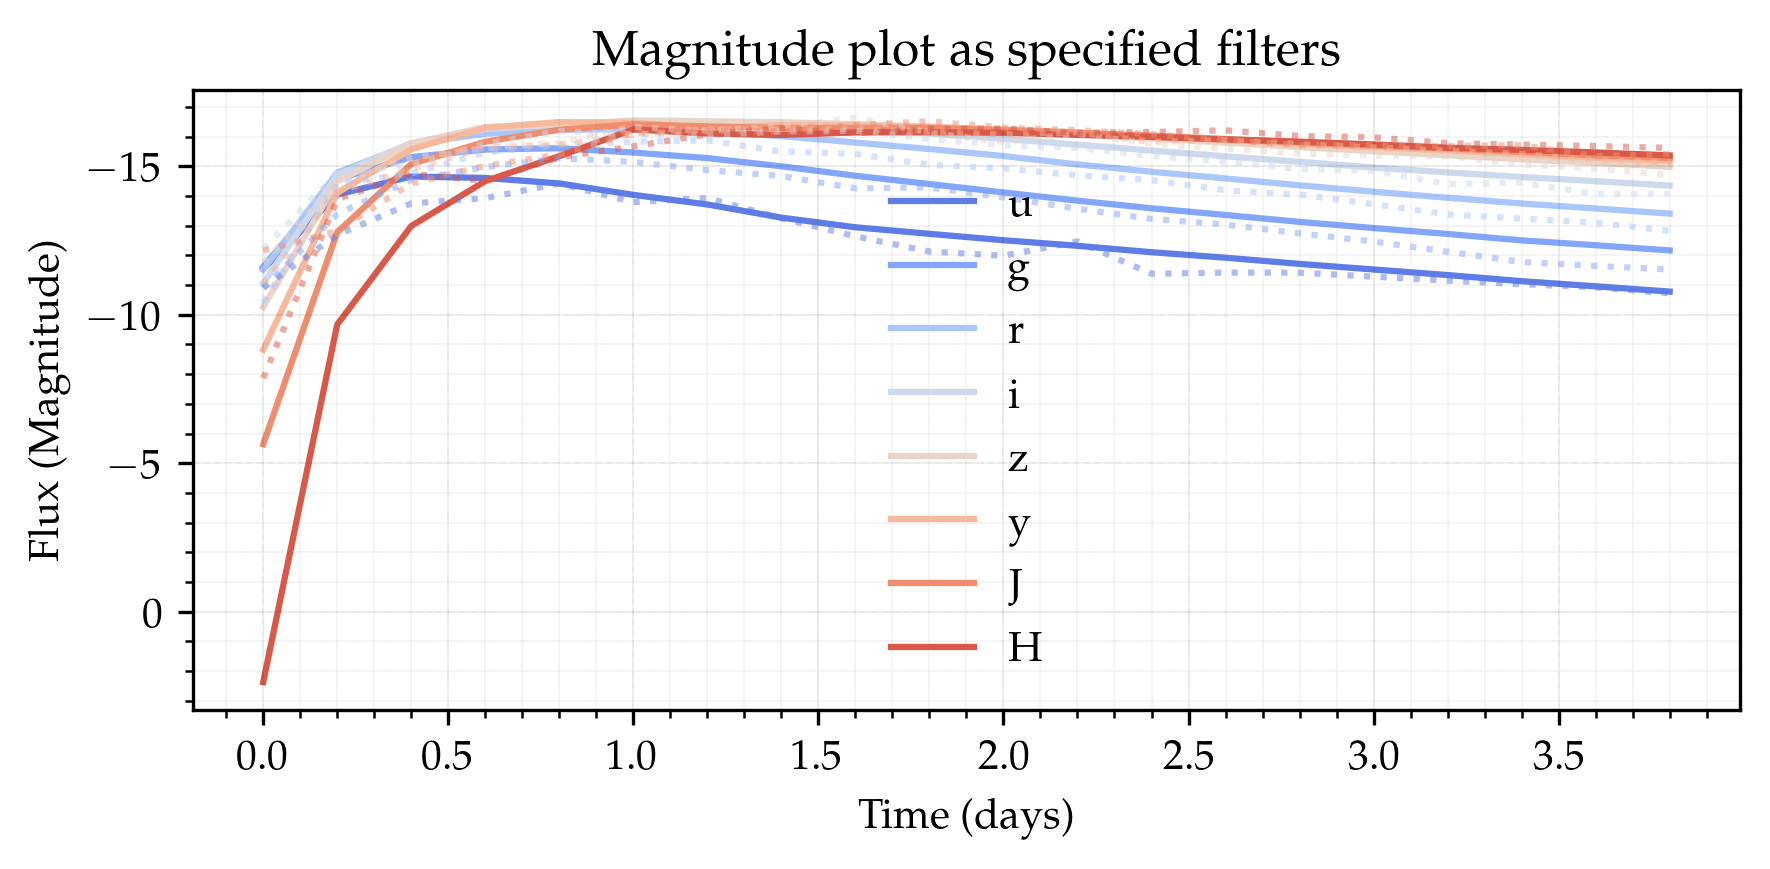

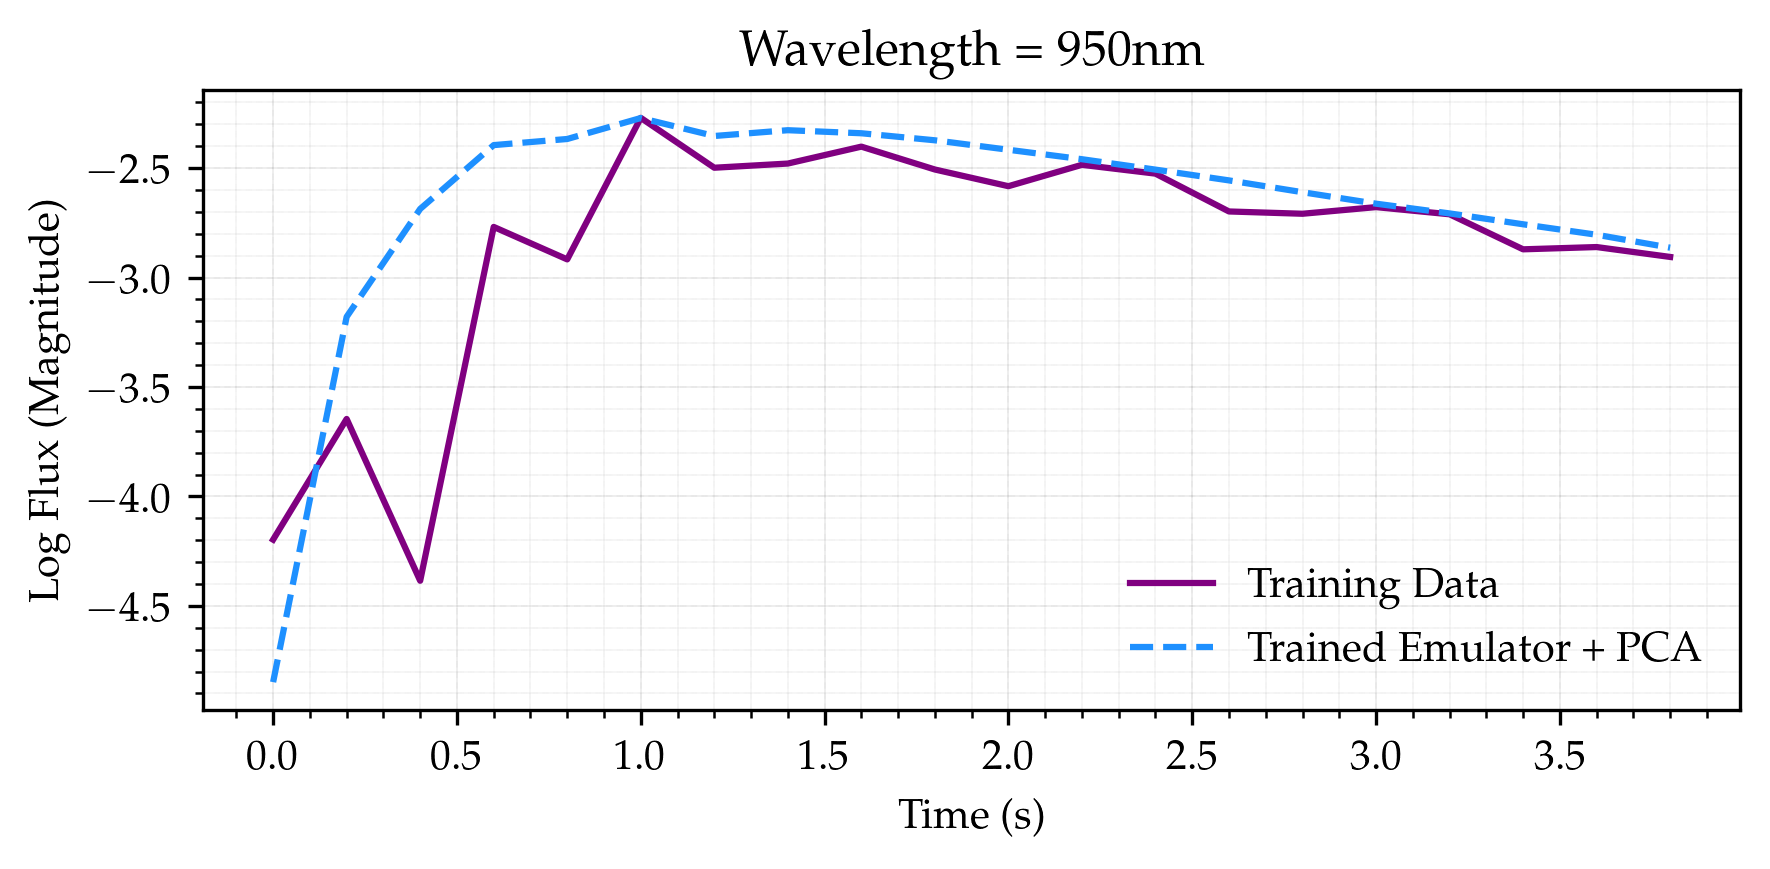

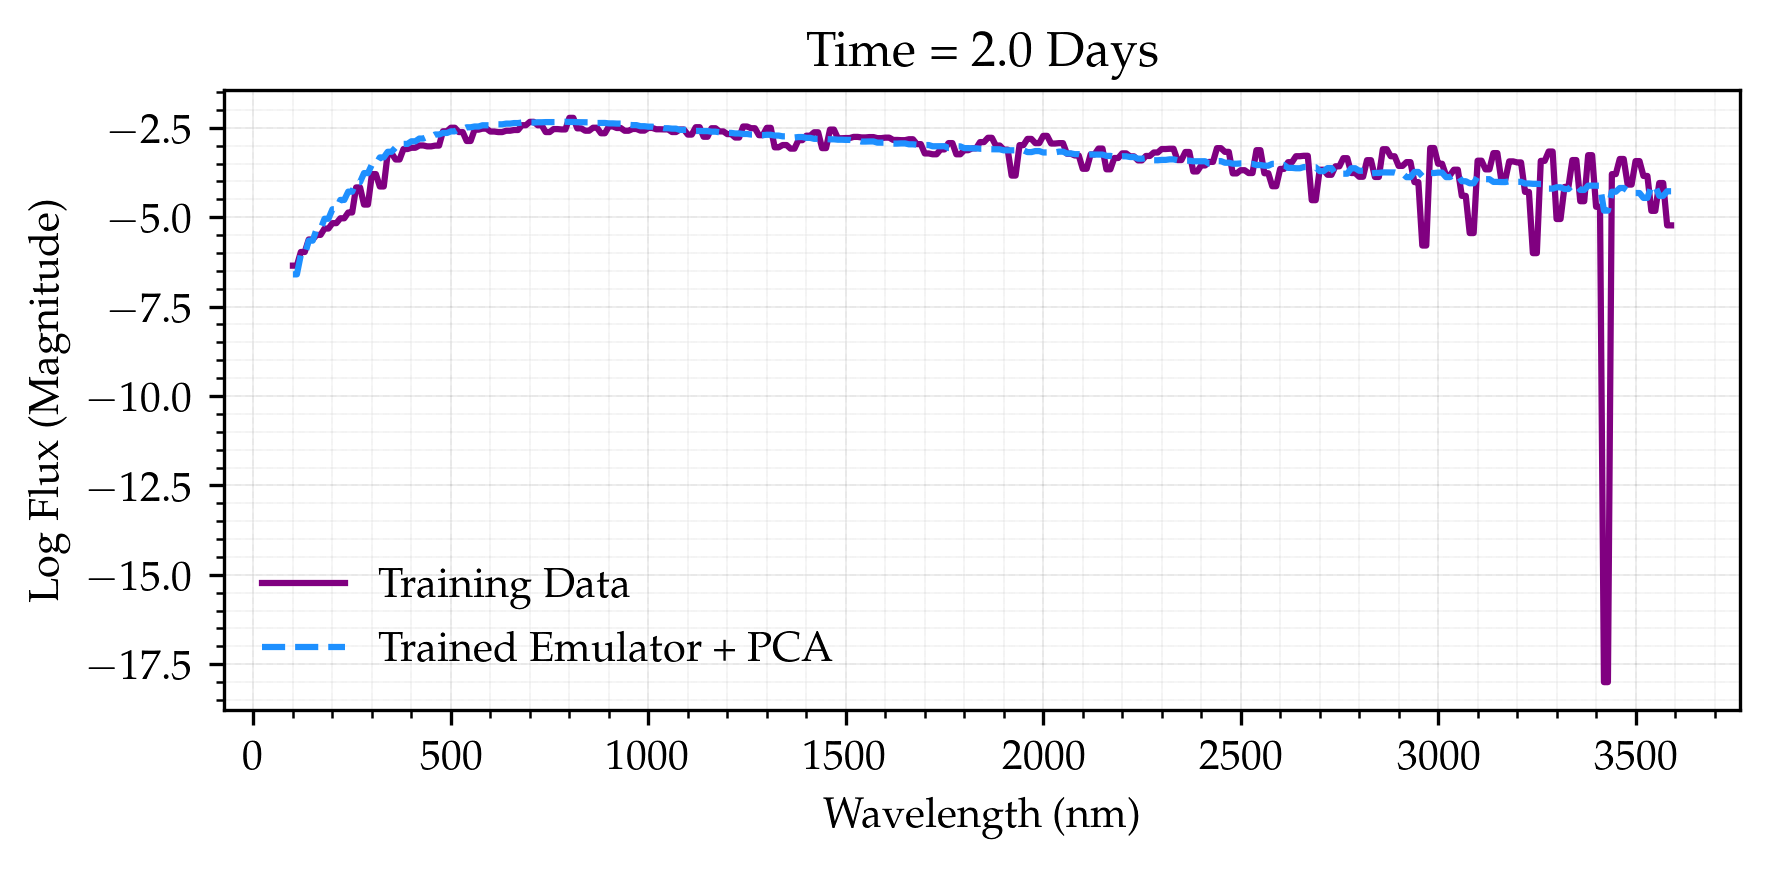

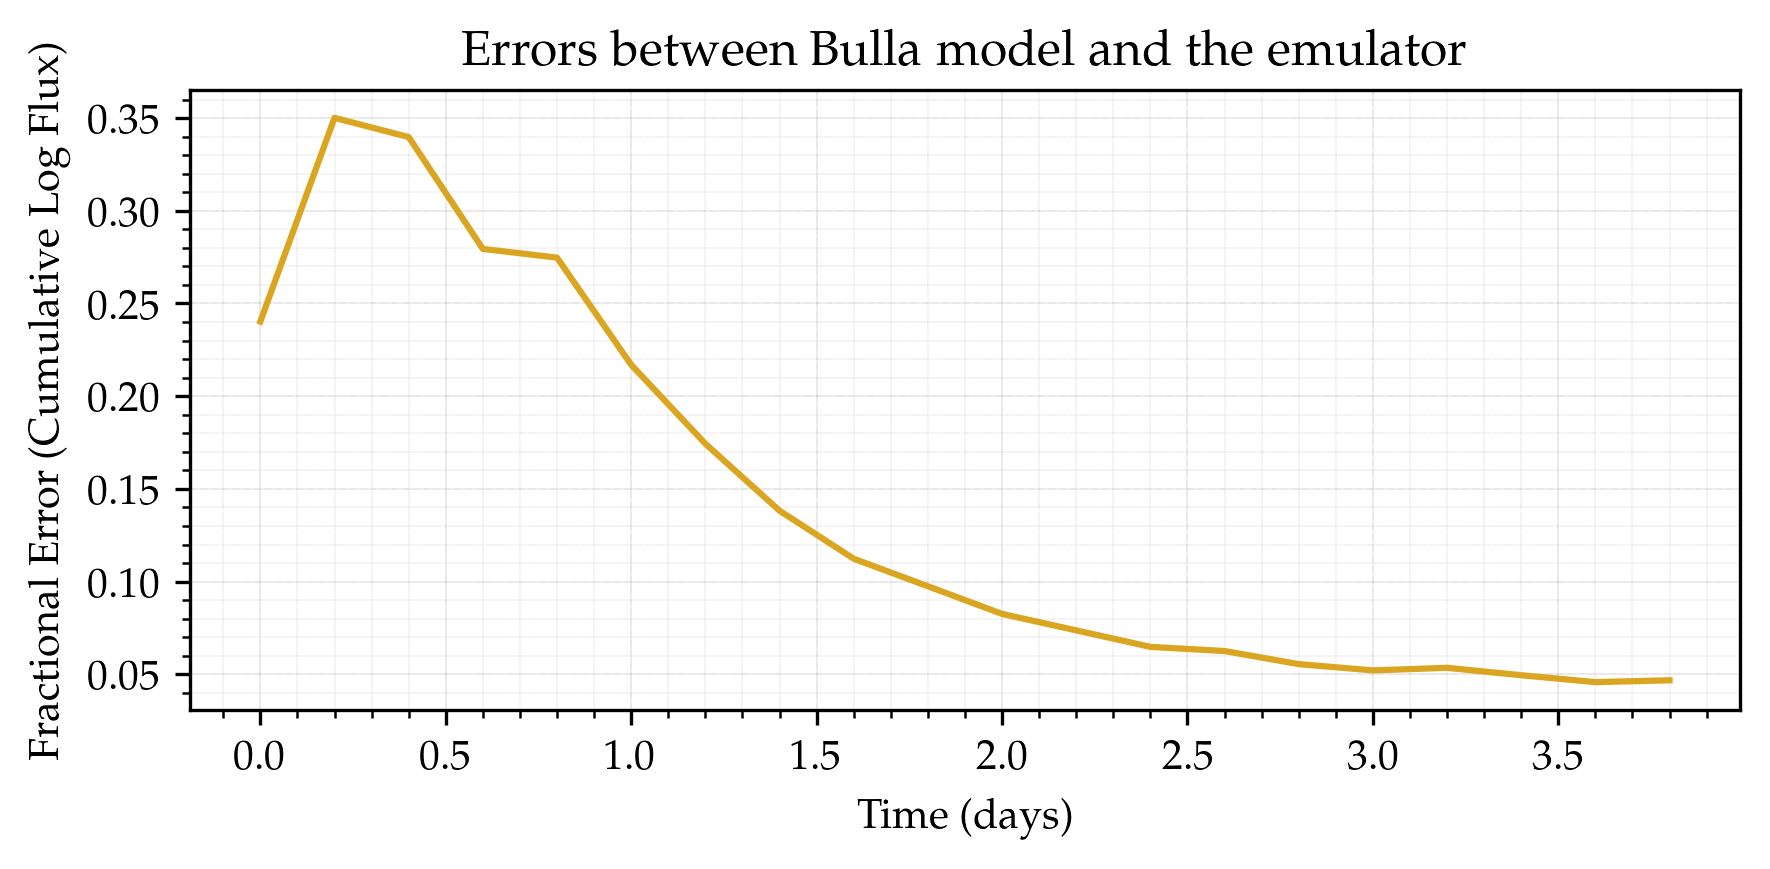

In [5]:
gp.get_flux(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2, wv_desired = 950)
gp.plot_filters(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs)
gp.overplot_time(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, wv_desired = 950)
gp.overplot_wavelength(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2)
gp.plot_emulator_errors()
plt.show()

[STATUS] Setting X, Y components for 5D Model.
[STATUS] Optimizing...
Optimization restart 1/3, f = 237357.69184024242
Optimization restart 2/3, f = 241526.65750049526
Optimization restart 3/3, f = 269046.4065405355
[STATUS] 47.84s taken to optimize.


index,GP_regression.mul.rbf.lengthscale,constraints,priors
[0],0.00000249,+ve,
[1],0.03806972,+ve,
[2],0.00000047,+ve,
[3],0.77128819,+ve,


[STATUS] Predicting X and Y with trained emulator.
[STATUS] 0.005s taken to predict single item.
[STATUS] Predicting X and Y with trained emulator.


 /Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator/Classes/GP5D.py:292: RuntimeWarning:invalid value encountered in sqrt


[STATUS] 1.76s taken to predict every item.
[STATUS] 8.08s taken to save data.
Inside 3x: 28000, Total: 28000


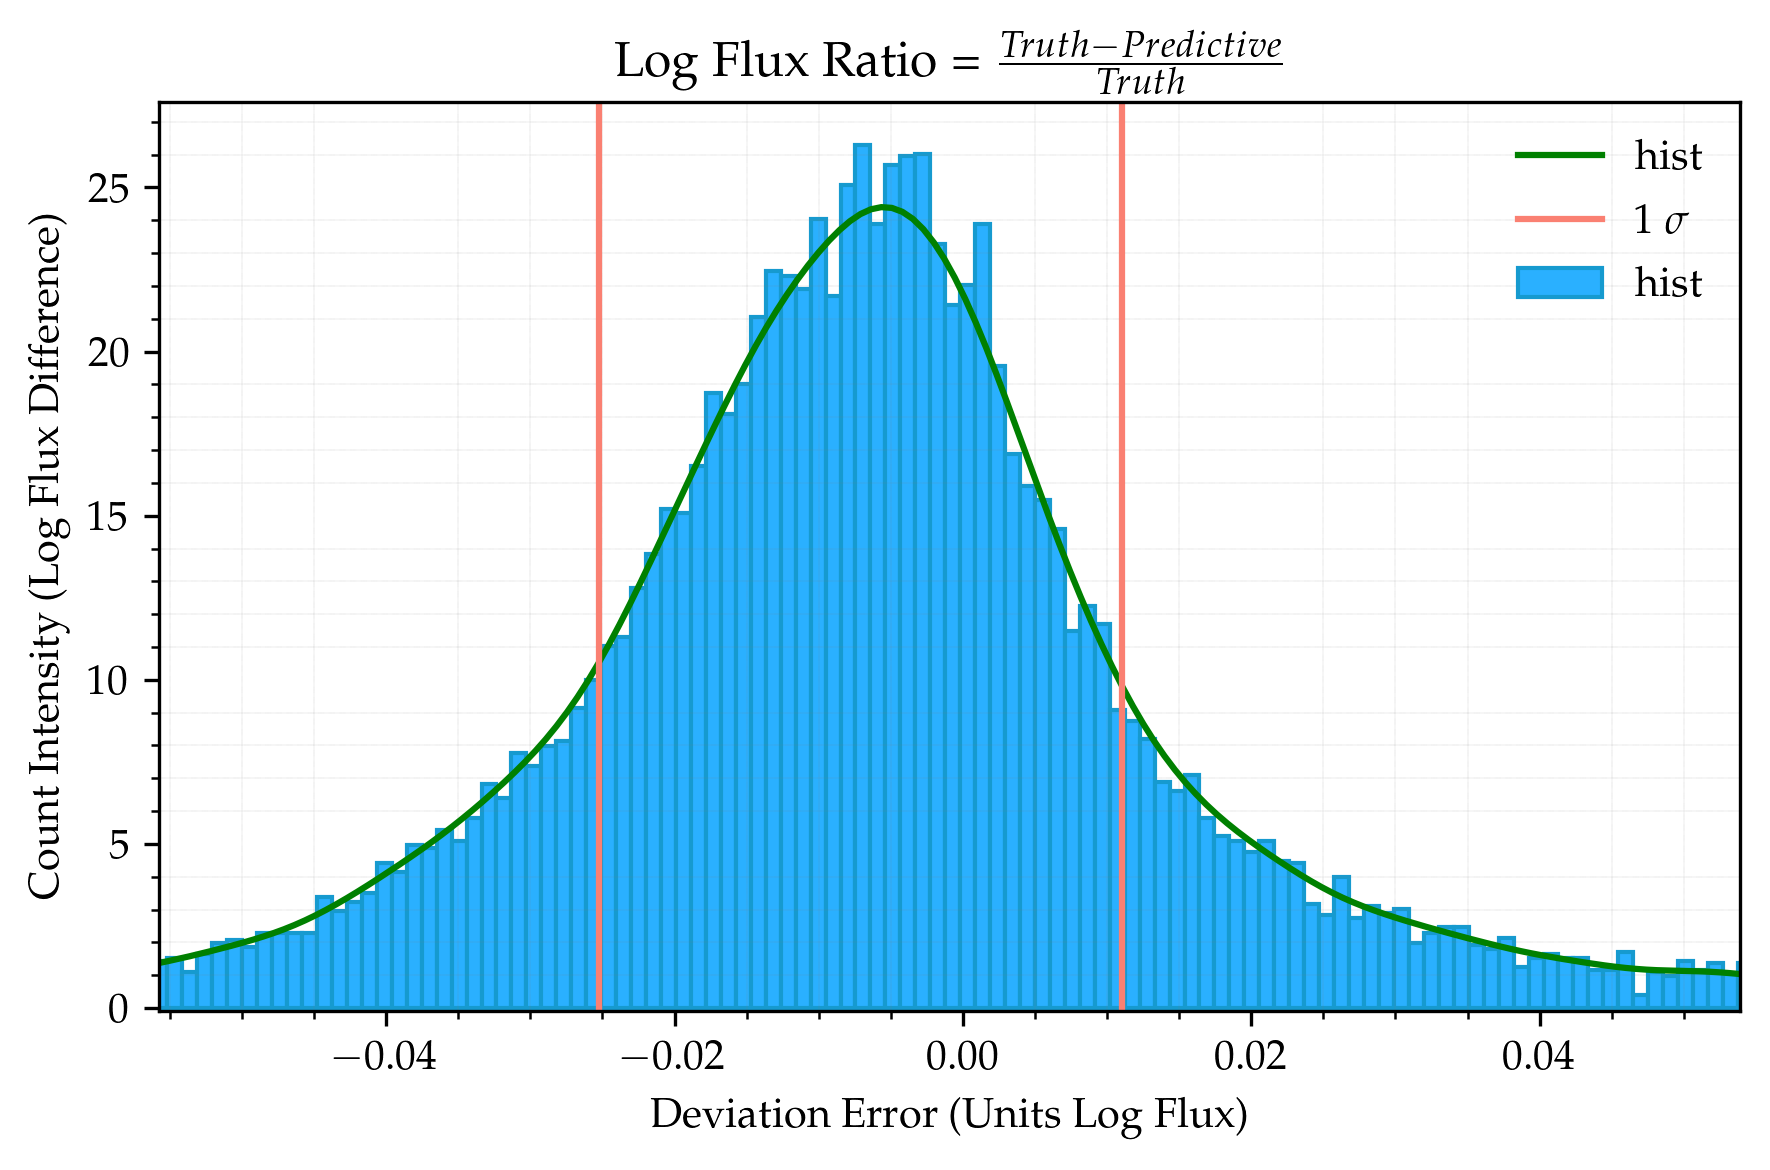

In [6]:
gp = GP5D("Classes/reference.csv")
gp.split = gpSplit
gp.emulator = "end"
gp.cross_validation = (mejdyn, mejwind, phi, iobs)
gp.set_wv_range(curr_wv)
gp.n_comp = 25
time_shape = None
# gp.save_training_data(time_trauncation = time_shape) # Which wv do you want to extract.  
gp.save_pca_components(skip_factor = set_skip_factor)
gp.setXY_cross_validation(mejdyn, mejwind, phi, iobs)
fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 10, lengthscale=10, ARD = True)
decay_kernel = GPy.kern.Linear(input_dim=4, ARD = True)
gp.kernel = fitting_kernel * decay_kernel
gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
t0 = time.time()
print(f"[STATUS] Optimizing...")
gp.model.optimize_restarts(parallel = True, robust = True, num_restarts = 3)
print(f"[STATUS] {round(time.time() - t0, 2)}s taken to optimize.")
# gp.model.optimize(messages = True)
# display(gp.model.rbf.lengthscale)
display(gp.model.mul.rbf.lengthscale)
t1 = time.time()
gp.model_predict_cross_validation(include_like = True) # Save cross validation
print(f"[STATUS] {round(time.time() - t1, 3)}s taken to predict single item.")
gp.model_predict(include_like = True)
print(f"[STATUS] {round(time.time() - t1, 2)}s taken to predict every item.")
t2 = time.time()
gp.save_trained_data()
print(f"[STATUS] {round(time.time() - t2, 2)}s taken to save data.")
gp.ComputeDifferenceFlux()
gp.plot_difference_histogram(binning = 350)
plt.show()

=== Flux Estimation === 
mejdyn: 0.01
mejwind: 0.13        
phi: 45
viewing_angle: 4
wavelength: 950nm        
time: 4.0 days

LOG FLUX: -2.88503


100%|██████████| 196/196 [00:00<00:00, 230.70it/s]


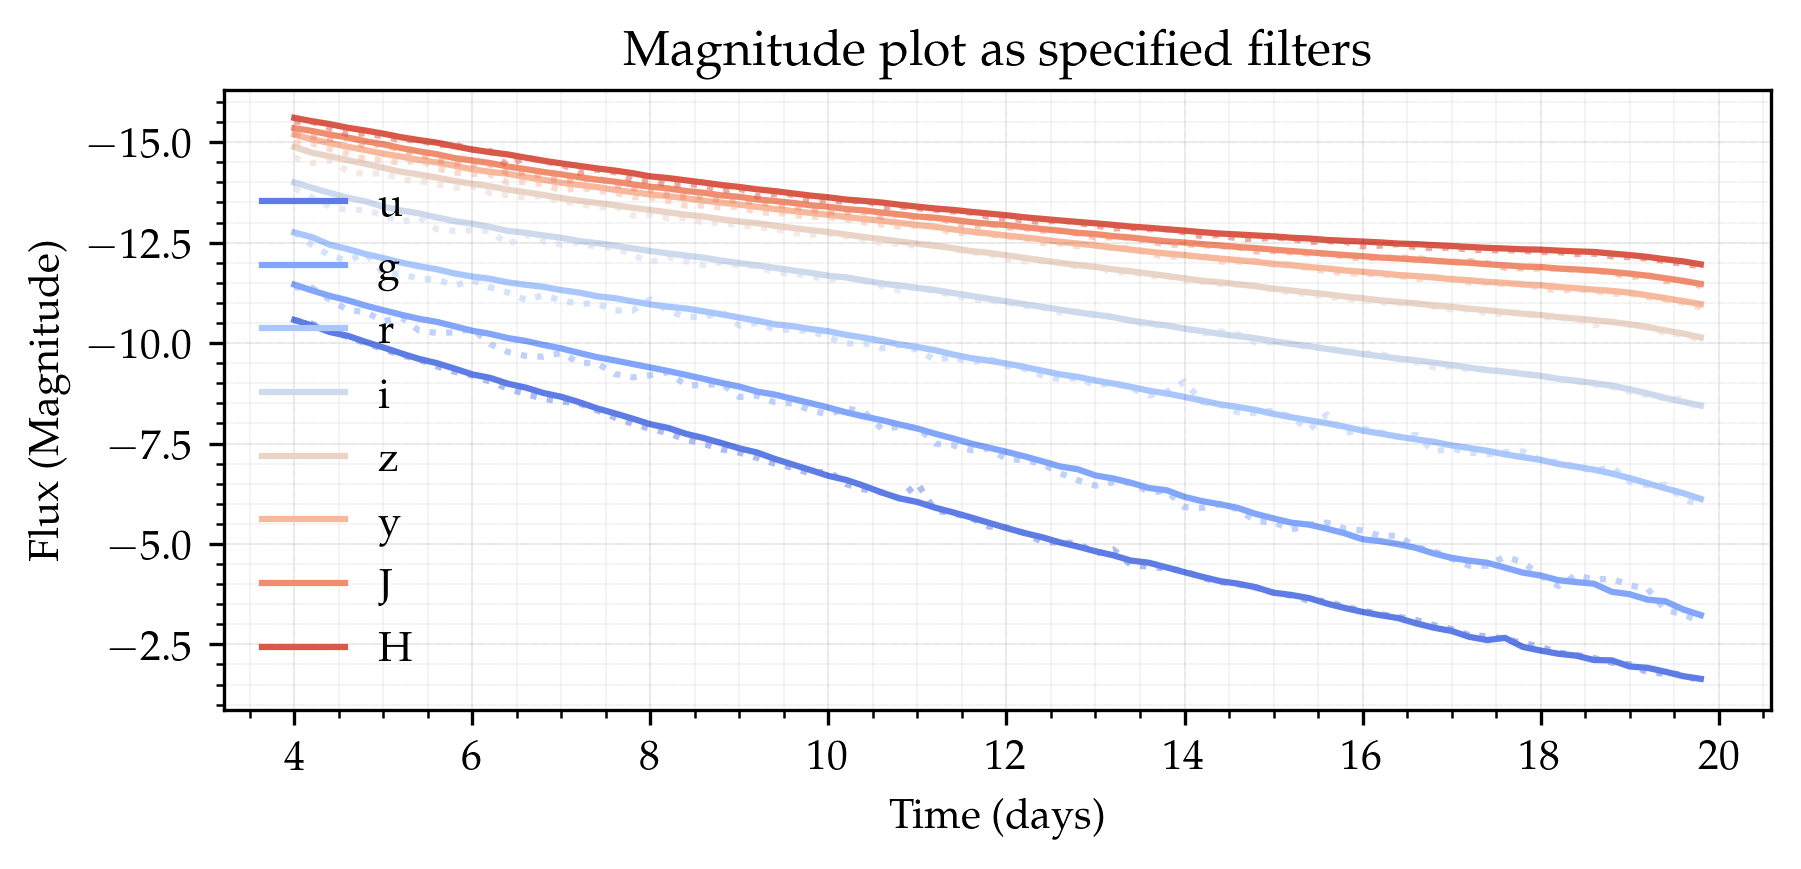

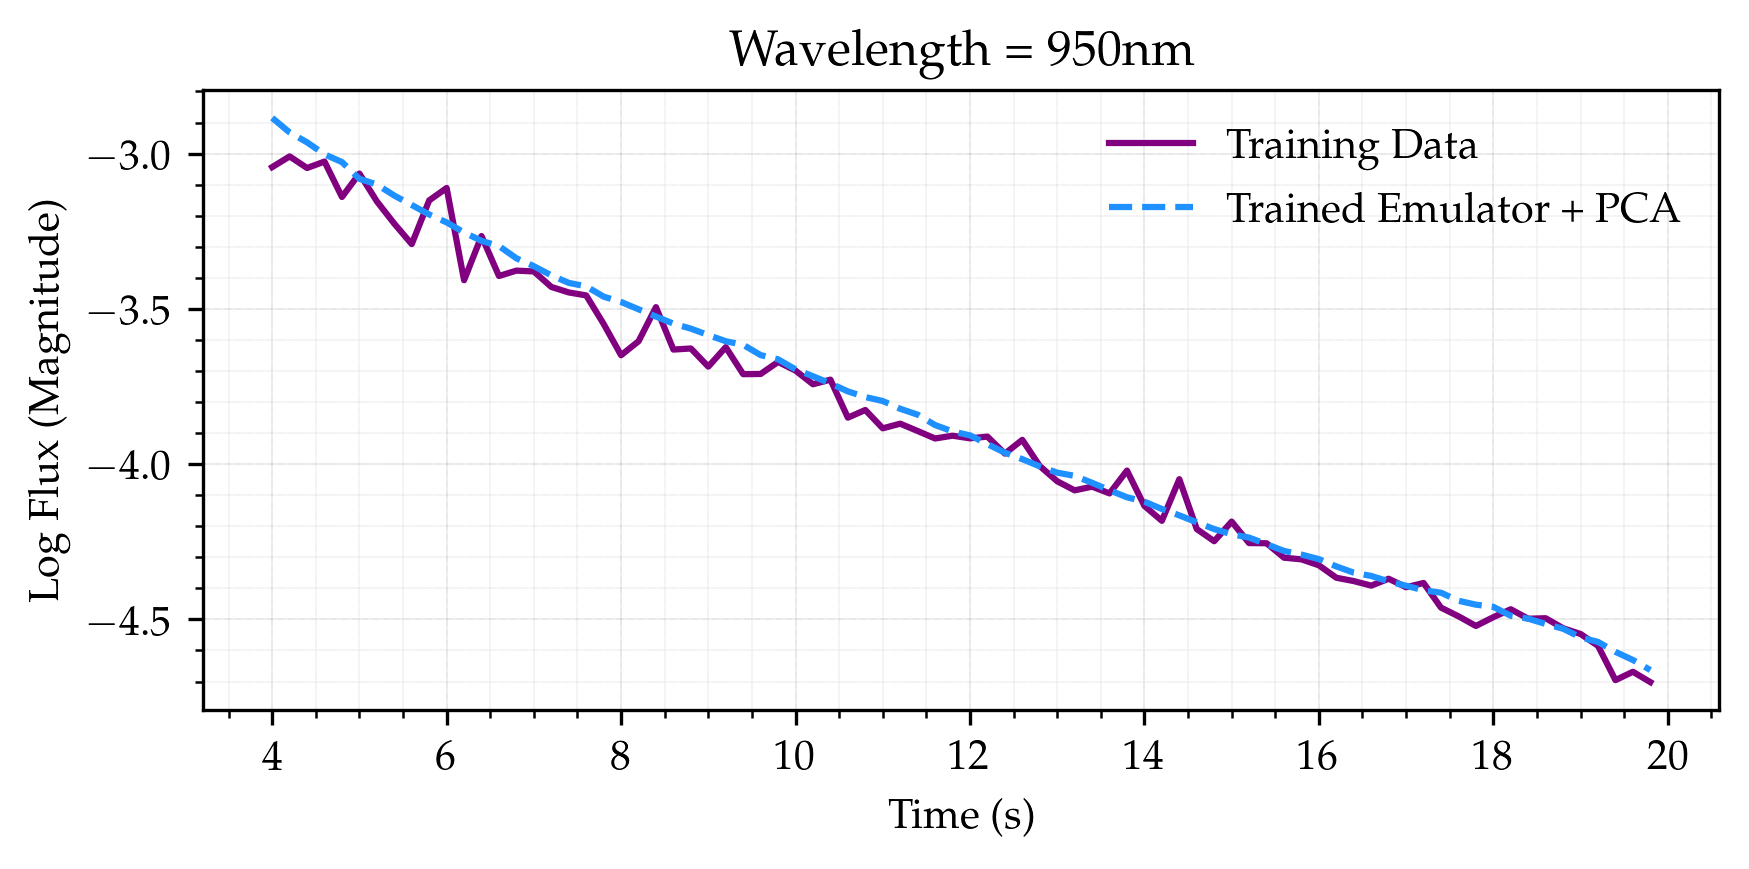

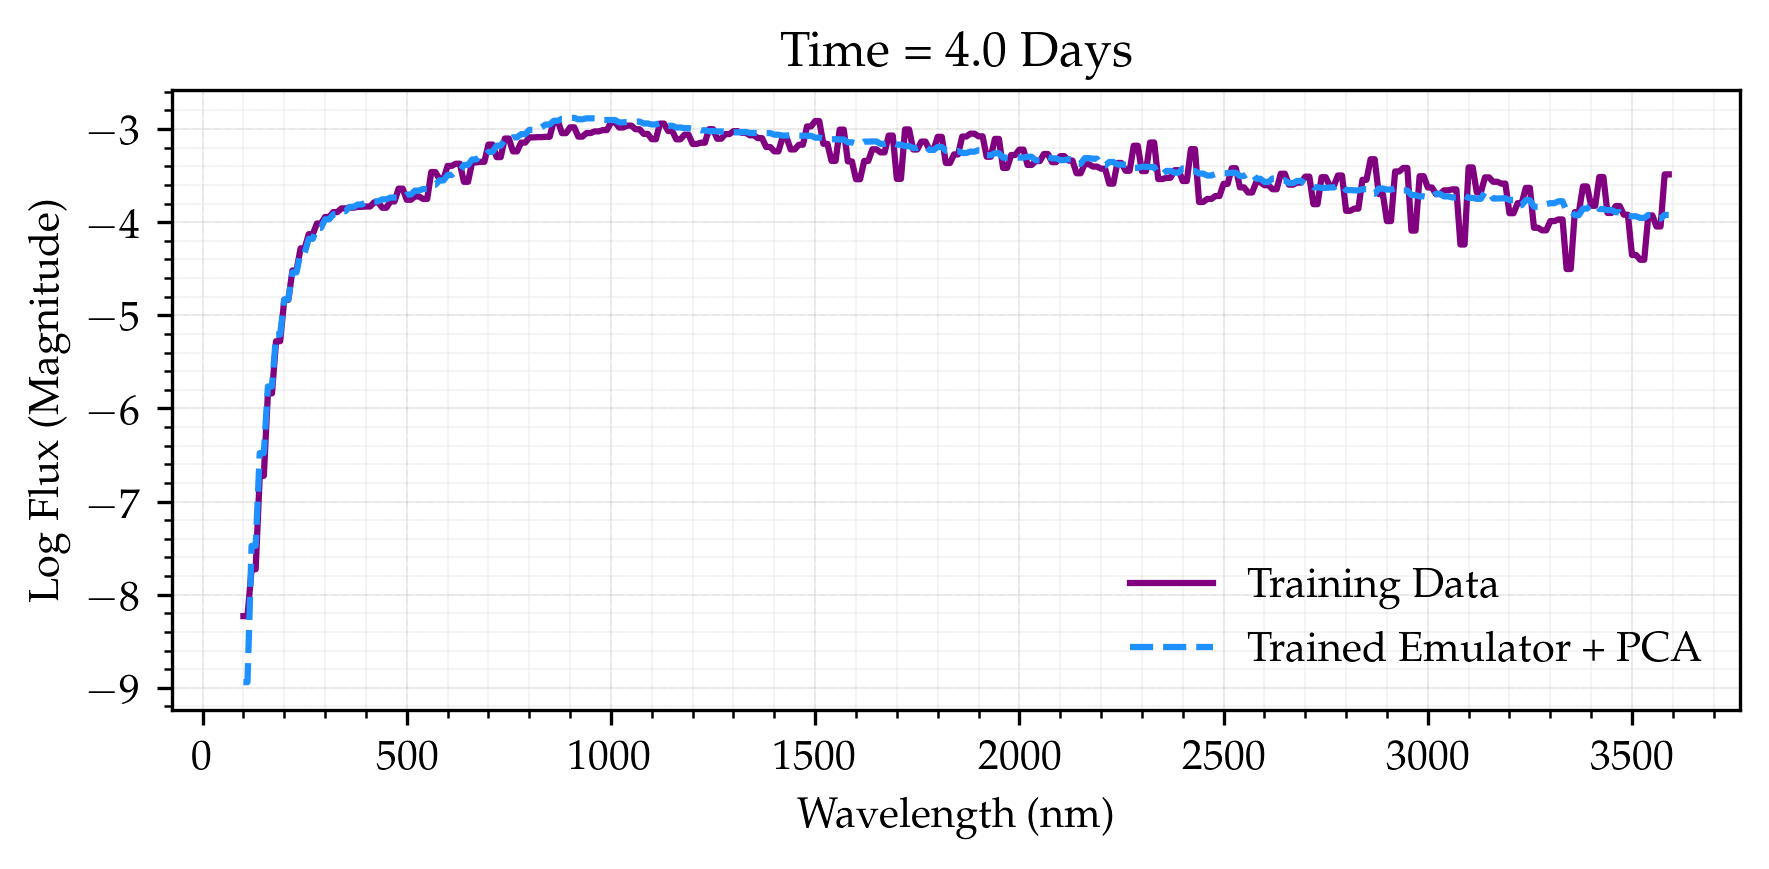

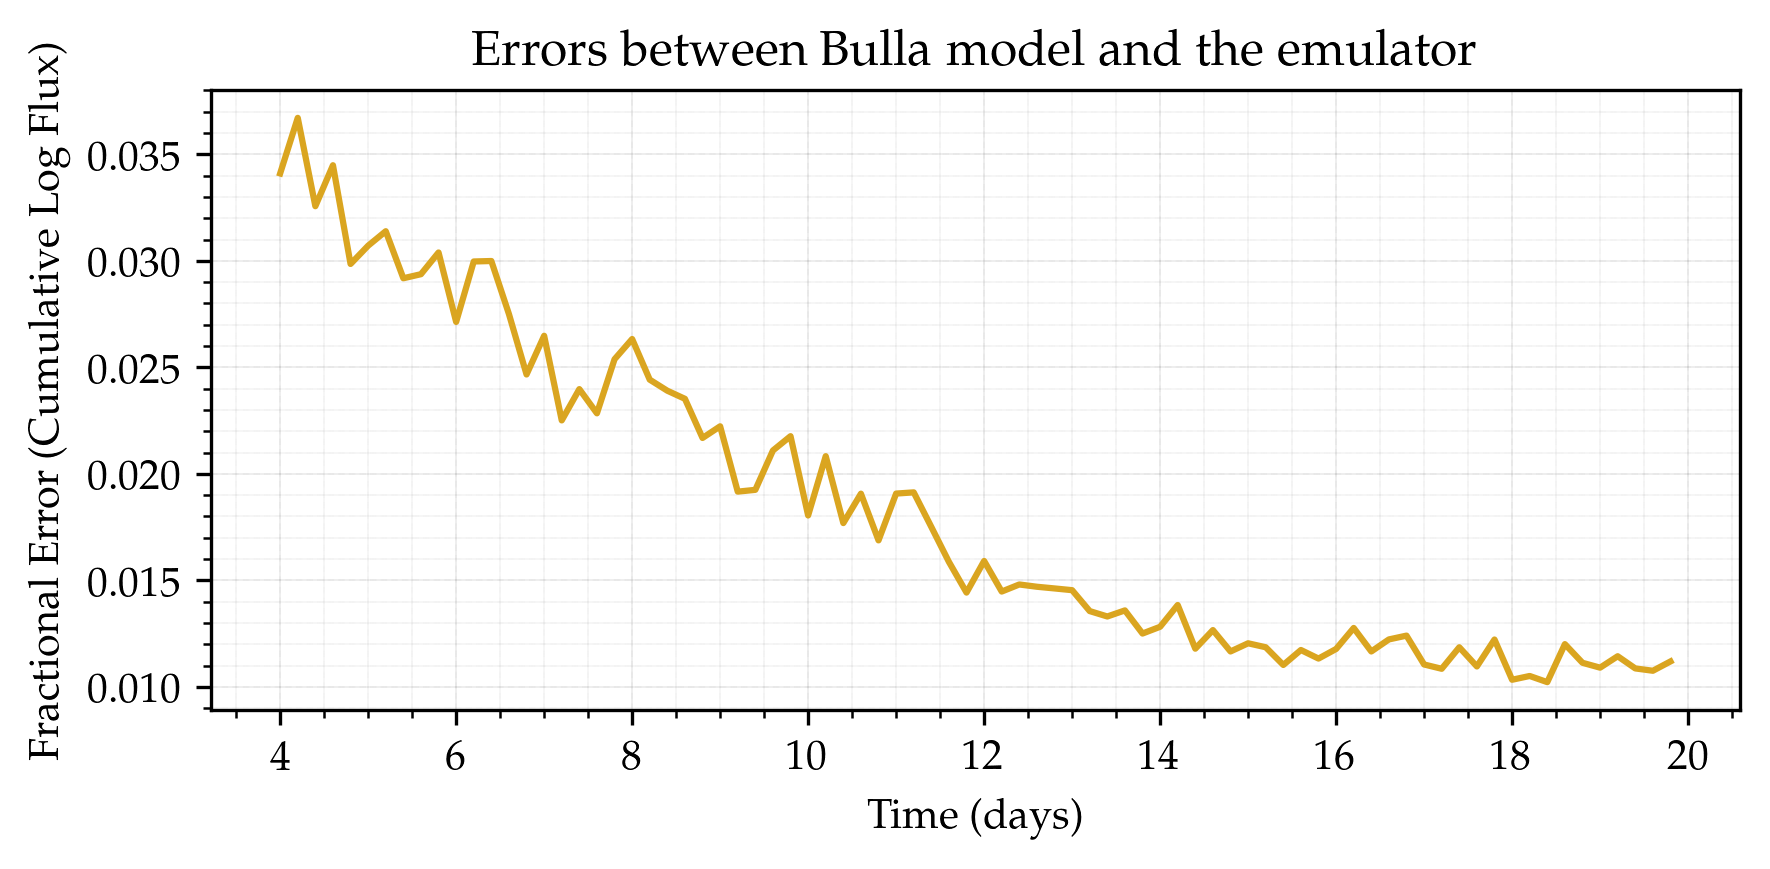

In [7]:
gp.get_flux(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2, wv_desired = 950)
gp.plot_filters(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs)
gp.overplot_time(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, wv_desired = 950)
gp.overplot_wavelength(mejdyn = mejdyn, mejwind =  mejwind, phi = phi, iobs = iobs, time_desired = 2)
gp.plot_emulator_errors()
plt.show()